# **Convert Velodyne-data to Top-View Image** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)  

refer to [KITTI Dataset Paper](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) for the details of data measurement environment

## Objective

Convert Velodyne data(model : HDL-64E) to Top-view image.
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj

# bin file -> numpy array
velo_points = load_from_bin('./velodyne_points/data/0000000089.bin')

print(velo_points.shape)

(123749, 4)


(-0.5, 400.5, 400.5, -0.5)

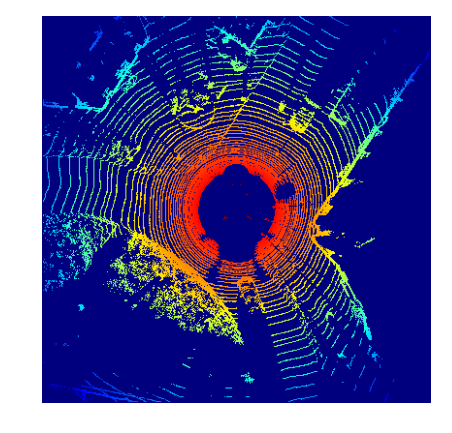

In [2]:
def normalize_depth(val, min_v, max_v):
    """ 
    print 'normalized depth value' 
    normalize values to 0-255 & close distance value has high value. (similar to stereo vision's disparity map)
    """
    return (((max_v - val) / (max_v - min_v)) * 255).astype(np.uint8)

def in_range_points(points, x, y, z, x_range, y_range, z_range):
    """ extract in-range points """
    return points[np.logical_and.reduce((x > y_range[0], x < y_range[1], y > x_range[0], \
                                         y < x_range[1], z > z_range[0], z < z_range[1]))]

def velo_points_2_top_view(points, x_range, y_range, z_range, scale):
    
    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2)
    
    # extract in-range points
    x_lim = in_range_points(x, x, y, z, x_range, y_range, z_range)
    y_lim = in_range_points(y, x, y, z, x_range, y_range, z_range)
    dist_lim = in_range_points(dist, x, y, z, x_range, y_range, z_range)
    
    x_size = int((x_range[1] - x_range[0]))
    y_size = int((y_range[1] - y_range[0]))
    
    # convert 3D lidar coordinates(vehicle coordinates) to 2D image coordinates
    # Velodyne coordinates info : http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
    # scale - for high resolution
    x_img = -(y_lim * scale).astype(np.int32)
    y_img = -(x_lim * scale).astype(np.int32)

    # shift negative points to positive points (shift minimum value to 0)
    x_img += int(np.trunc(x_range[1] * scale))
    y_img += int(np.trunc(y_range[1] * scale))

    # normalize distance value & convert to depth map
    max_dist = np.sqrt((max(x_range)**2) + (max(y_range)**2))
    dist_lim = normalize_depth(dist_lim, min_v=0, max_v=max_dist)
    
    # array to img
    img = np.zeros([y_size * scale + 1, x_size * scale + 1], dtype=np.uint8)
    img[y_img, x_img] = dist_lim
    
    return img

# Plot result
top_image = velo_points_2_top_view(velo_points, x_range=(-20, 20), y_range=(-20, 20), z_range=(-2, 2), scale=10)
plt.subplots(1,1, figsize = (5,5))
plt.imshow(top_image)
plt.axis('off')
    

(-0.5, 300.5, 200.5, -0.5)

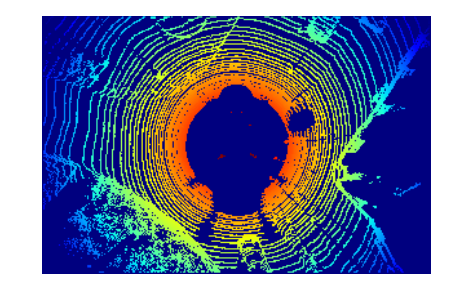

In [3]:
""" different range's result """

top_image = velo_points_2_top_view(velo_points, x_range=(-15, 15), y_range=(-10, 10), z_range=(-2, 2), scale=10)
plt.subplots(1,1, figsize = (5,5))
plt.imshow(top_image)
plt.axis('off')

## Save Top-View Video

In [4]:
import glob
import cv2

lidar_points = glob.glob('./velodyne_points/data/*.bin')

# pre define range for image size
x_range, y_range, z_range, scale = (-20,20), (-20,20), (-2, 2), 10
size = int((max(x_range)-min(x_range)) * scale), int((max(y_range)-min(y_range)) * scale)

""" save top view video """
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('topview.mp4', fourcc, 25.0, size, False)

for point in lidar_points:
    velo = load_from_bin(point)
    img = velo_points_2_top_view(velo, x_range=x_range, y_range=y_range, z_range=z_range, scale=scale)
    vid.write(img)

print('video saved')
vid.release()   

video saved


## Display Top-View Video

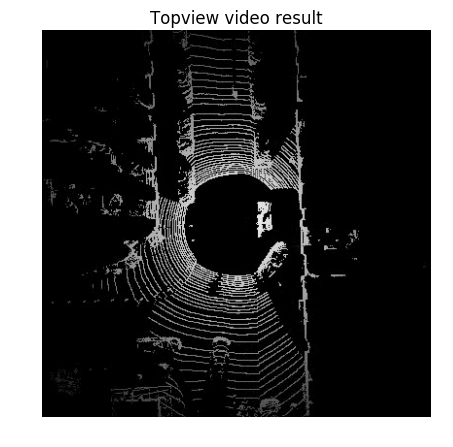

In [5]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./topview.mp4")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,5))
    
    plt.title("Topview video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()